In [21]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

main_dir = 'C:/Users/jtrum/world_bank/'
aoi = gpd.read_file(main_dir + 'data/luanda2clean.geojson')
catchment = gpd.read_file(main_dir + 'data/catchment.geojson')
aoi = aoi.to_crs(epsg=4326)
catchment = catchment.to_crs(epsg=4326)


#make fishnet grid
def createGrid(polygon, gridSize):
    xmin, ymin, xmax, ymax = polygon.bounds #creates bounding box of 'co' polygon
    rows = int(np.ceil((ymax-ymin)/gridSize)) #number of rows
    cols = int(np.ceil((xmax-xmin)/gridSize)) #number of columns
    polygons = [] #empty list to hold polygons
    for i in range(cols):
        for j in range(rows):
            polygons.append(Polygon([(xmin+i*gridSize, ymin+j*gridSize), 
                                     (xmin+(i+1)*gridSize, ymin+j*gridSize), 
                                     (xmin+(i+1)*gridSize, ymin+(j+1)*gridSize), 
                                     (xmin+i*gridSize, ymin+(j+1)*gridSize)]))
    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.crs = {'init':'epsg:4326'}
    grid = grid[grid.geometry.within(polygon)] #keep only grid cells within 'co' polygon
    return grid

#determine distance to nearest water infrastructure point for each grid cell
def distance_to_nearest(row, destination, val):
    #row is a row of the grid dataframe
    #destination is the water infrastructure point dataframe
    #val is the value to return if there are no water infrastructure points
    if len(destination) == 0:
        return val
    else:
        dist = destination.distance(row['geometry'])
        return dist.min()



tags_list = [
    {'waterway': True},
    {'landuse': ['reservoir', 'basin']},
    {'amenity': ['drinking_water', 'watering_place', 'water_point']},
    {'man_made': ['water_well', 'water_tower', 'water_works', 'reservoir_covered', 'storage_tank', 'monitoring_station', 'wastewater_plant', 'watermill', 'pipeline']}
]        

water_infrastructure = pd.DataFrame(columns=['feature', 'geometry'])

for tags in tags_list:
    data = ox.geometries_from_polygon(aoi.geometry[0], tags=tags)
    data = data[['geometry']]
    data['feature'] = list(tags.keys())[0]  # Extract the feature type from the tags
    water_infrastructure = water_infrastructure.append(data)

water_infrastructure = water_infrastructure.reset_index(drop=True)
water_infrastructure = gpd.GeoDataFrame(water_infrastructure, geometry='geometry', crs=aoi.crs)

# in 'water_infrastructure', give a value of 1 if the feature is a waterway, and 0 if it is not, in a column called 'layer'
water_infrastructure['layer'] = water_infrastructure['feature'].apply(lambda x: 1 if x == 'waterway' else 0)
#turn into geodataframe
water_infrastructure = gpd.GeoDataFrame(water_infrastructure, geometry='geometry') 

#convert water_infrastructure crs into one that measures distance in meters
water_infrastructure = water_infrastructure.to_crs(epsg=32632)
aoi = aoi.to_crs(epsg=32632)
catchment = catchment.to_crs(epsg=32632)
water_infrastructure

#make a subset of water_infrastructure to include only 0 values in the 'layer' column
water_infrastructure_0 = water_infrastructure[water_infrastructure['layer'] == 0].reset_index().drop(columns=['index'])
water_infrastructure_0['geometry'] = water_infrastructure_0['geometry'].centroid #take centroids of all of the polygons in water_infrastructure_0 to get point data
#make a subset of water_infrastructure to include only 1 values in the 'layer' column
water_infrastructure_1 = water_infrastructure[water_infrastructure['layer'] == 1].reset_index().drop(columns=['index'])

#make a fishnet grid of Philadelphia
gridSize = 750 #grid size in meters
grid = createGrid(aoi.geometry[0], gridSize)

print('Number of grid cells: ', len(grid))
grid = grid.reset_index().rename(columns={'index':'grid_id'})    
grid['dist_to_water_infrastructure'] = grid.apply(lambda row: distance_to_nearest(row, water_infrastructure_0, 0), axis=1)
grid['dist_to_water_infrastructure'] = grid['dist_to_water_infrastructure'].astype(int)

C:\Users\jtrum\AppData\Local\Temp\ipykernel_9492\3555289031.py:55: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  data = ox.geometries_from_polygon(aoi.geometry[0], tags=tags)
C:\Users\jtrum\AppData\Local\Temp\ipykernel_9492\3555289031.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  water_infrastructure = water_infrastructure.append(data)
c:\Users\jtrum\miniconda3\envs\wash_scan\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
C:\Users\jtrum\AppData\Local\Temp\ipykernel_9492\3555289031.py:55: UserWarning: The `geometries` module and `geometri

Number of grid cells:  4087


In [1]:
#ax = catchment.plot(color='black', edgecolor='black', alpha=0.1)
ax = grid.plot(column='dist_to_water_infrastructure', cmap='summer', legend=True, figsize=(16, 16), aspect='equal')
ax = water_infrastructure_1.plot(ax=ax, color='blue', alpha=0.25, edgecolor='blue')
# add points of water infrastructure
ax = water_infrastructure_0.plot(ax=ax, alpha=1, color='black', markersize=1, edgecolor='black')
# No ticks
ax.set_xticks([])
ax.set_yticks([])
# No frame
ax.set_frame_on(False)
# Change font to Helvetica
plt.rcParams['font.family'] = 'Arial'
# Add title
plt.title('Distance to Nearest Water\n Infrastructure Point in Luanda, Angola', fontsize=16);


NameError: name 'grid' is not defined

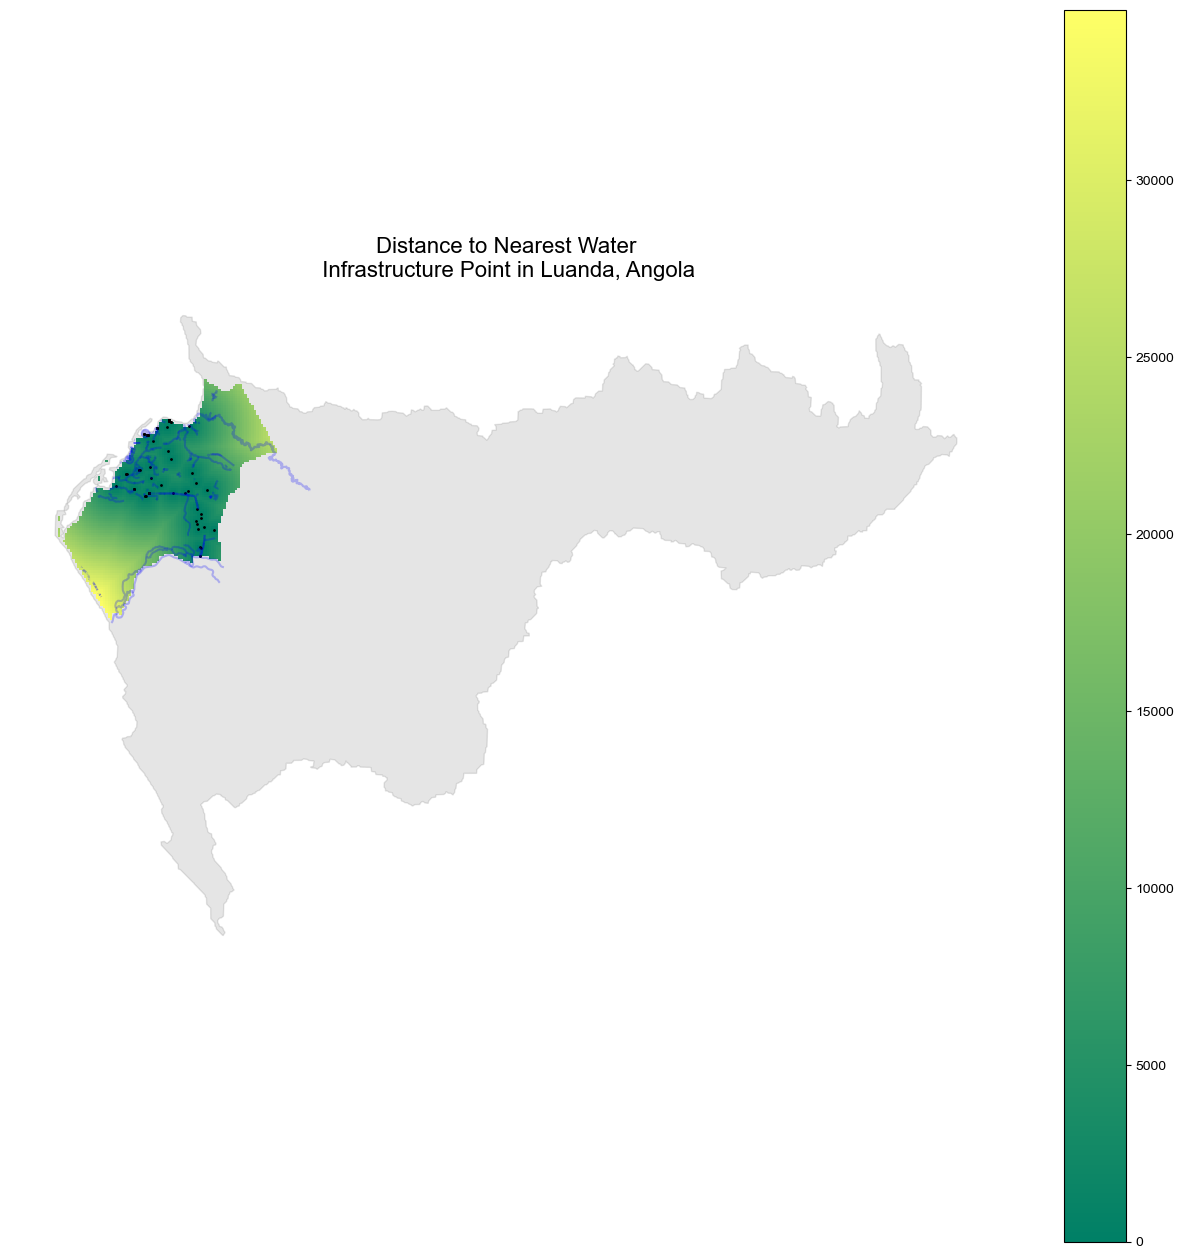

In [20]:
catchment = catchment.to_crs(aoi.crs)
ax = catchment.plot(color='black', edgecolor='black', alpha=0.1, figsize=(16, 16))
ax = grid.plot(ax=ax, column='dist_to_water_infrastructure', cmap='summer', legend=True, figsize=(16, 16), aspect='equal')
ax = water_infrastructure_1.plot(ax=ax, color='blue', alpha=0.25, edgecolor='blue')
# add points of water infrastructure
ax = water_infrastructure_0.plot(ax=ax, alpha=1, color='black', markersize=1, edgecolor='black')
# No ticks
ax.set_xticks([])
ax.set_yticks([])
# No frame
ax.set_frame_on(False)
# Change font to Helvetica
plt.rcParams['font.family'] = 'Arial'
# Add title
plt.title('Distance to Nearest Water\n Infrastructure Point in Luanda, Angola', fontsize=16);
